# Exploiting the nested sampling

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.8.5


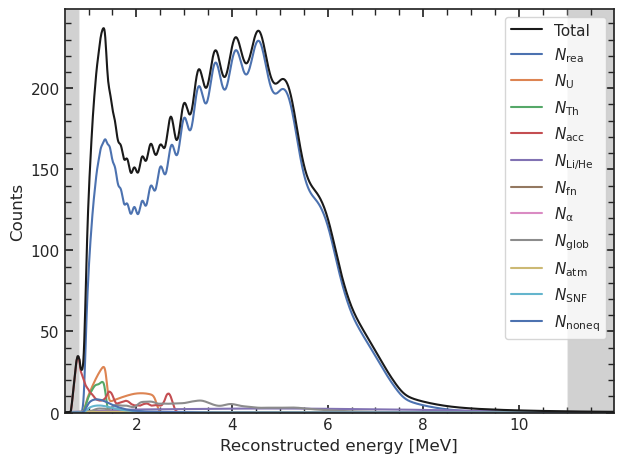

In [2]:
model = orsa.model.read_json('inputs/test_model.json')
model.exposure = 6*365.25
model

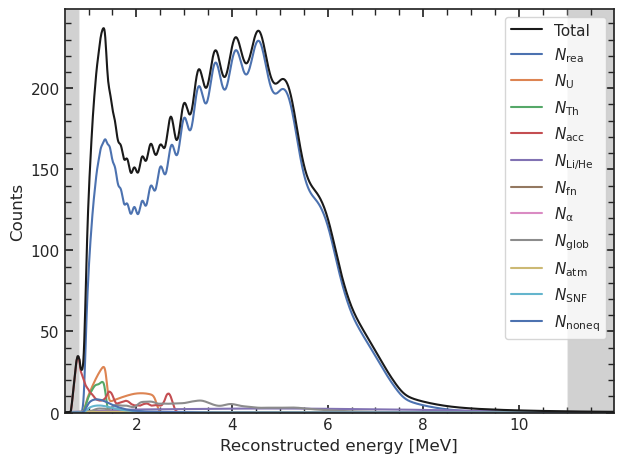

In [3]:
model

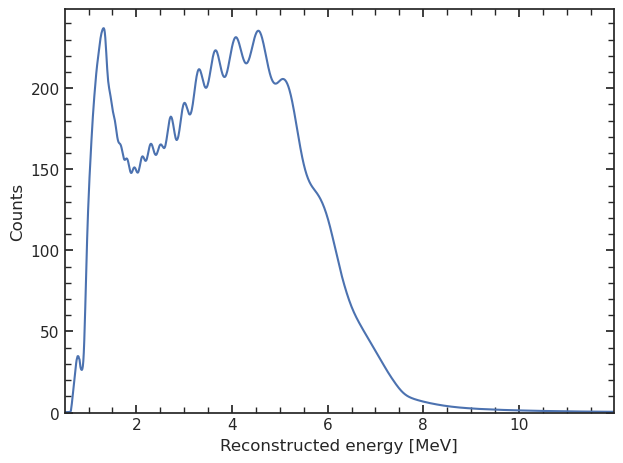

In [4]:
data = model.get_spectrum(asimov = True)
data

In [5]:
for param in model.detector_parameters:
    model.detector_parameters[param].fixed = True

for param in model.core_parameters:
    model.core_parameters[param].fixed = True

for param in model.normalization_parameters:
    if model.normalization_parameters[param].label != 'rea':
        model.normalization_parameters[param].fixed = True

model.parameters['rho'].fixed = True

In [6]:
init_model = model.copy()
model.use_shape_uncertainty = False
cf = orsa.probability.CostFunction(ll=orsa.probability.ll_binned, model=model, data=data, ll_args = dict())
true_values = cf.get_params_to_fit()[0]
res = orsa.fit.minuit(cf)
res.true_values = true_values

Cost function parsed as LogLikelihood-like


In [7]:
# Prepare priors for NestedSampling mapping

init_params, labels, init_errors, formatted_labels, _ = cf.get_params_to_fit()

for j, label in enumerate(labels):
    for i, model_ in enumerate(cf.model):
            for el in model_.parameters:
                param = model_.parameters[el]
                if f"{param.label}:{param.group}" not in labels:
                    if el in cf.lp_args[i]:
                        del cf.lp_args[i][el]

                if label == f"{param.label}:{param.group}":
                    if el in cf.lp_args[i]:
                        keys_ = list(cf.lp_args[i][el].keys())
                        if (('gauss' in cf.lp_args[i][el]) or ('flat' in cf.lp_args[i][el])) and (len(cf.lp_args[i][el]) == 1):
                            pass
                        elif (('gauss' in cf.lp_args[i][el]) or ('flat' in cf.lp_args[i][el])) and (len(cf.lp_args[i][el]) > 1):
                            if ('gauss' in cf.lp_args[i][el]):
                                for elll in keys_:
                                    if elll != 'gauss': del cf.lp_args[i][el][elll]
                            elif ('flat' in cf.lp_args[i][el]):
                                for elll in keys_:
                                    if elll != 'flat': del cf.lp_args[i][el][elll]

                            else:
                                del cf.lp_args[i][el]
                                cf.add_prior(param.label, 'flat', dict(left = res.obj.values[label] - 5*res.obj.errors[label], right = res.obj.values[label] + 5*res.obj.errors[label]), which_cf=i)
                            
                    else:
                        cf.add_prior(param.label, 'flat', dict(left = res.obj.values[label] - 5*res.obj.errors[label], right = res.obj.values[label] + 5*res.obj.errors[label]), which_cf=i)

cf.lp_args


array([{'a': {'gauss': {'mean': 0.02614, 'sigma': 0.00020127800000000002}}, 'b': {'gauss': {'mean': 0.006401, 'sigma': 7.6812e-05}}, 'c': {'gauss': {'mean': 0.01205, 'sigma': 0.00039765000000000004}}, 'a0': {'gauss': {'mean': 0, 'sigma': 1}}, 'a1': {'gauss': {'mean': 0, 'sigma': 1}}, 'a2': {'gauss': {'mean': 0, 'sigma': 1}}, 'a3': {'gauss': {'mean': 0, 'sigma': 1}}, 'rea': {'gauss': {'mean': 289459.05819689727, 'sigma': 5789.181163937947}}, 'dm2_21': {'flat': {'left': 7.460813435440854e-05, 'right': 7.599186564559146e-05}}, 'dm2_31': {'flat': {'left': 0.002507316258799649, 'right': 0.0025492837412003505}}, 's2_12': {'flat': {'left': 0.2994006388167867, 'right': 0.3145993611832133}}, 's2_13': {'flat': {'left': 0.009754087646378216, 'right': 0.03384591235362178}}}],
      dtype=object)

In [9]:
nested_path = 'inputs/test_nested.h5'
if os.path.isfile(nested_path):
    pass
    # res_mcmc = orsa.fit.parse_emcee(mcmc_path)
    # res_mcmc.labels = res_minuit.labels
    # res_mcmc.formatted_labels = res_minuit.formatted_labels
    # res_mcmc.true_values = res_minuit.true_values
    # res_mcmc.cost_function = res_minuit.cost_function
else:
    res_nested = orsa.fit.dynesty(cf, 1000, backend=None)
    res_nested.true_values = res.true_values

Cost function parsed as LogLikelihood-like


20548it [1:17:26,  3.98it/s, batch: 0 | bound: 114 | nc: 32 | ncall: 578752 | eff(%):  3.544 | loglstar:   -inf < -2950.816 <    inf | logz: -2971.495 +/-  0.137 | dlogz: 21.784 >  0.010]

In [ ]:
res_nested.get_samples(100000000000)
res_nested.to_json('inputs/test_nested.json')